<a id='top'></a><a name='top'></a>
# Chapter 7: Getting words in order with convolutional neural networks (CNNs)

* [Introduction](#introduction)
* [7.0 Imports and Setup](#7.0)
* [7.1 Learning meaning](#7.1)
* [7.2 Toolkit](#7.2)
* [7.3 Convolutional neural nets](#7.3)
    - [7.3.1 Building blocks](#7.3.1)
    - [7.3.2 Step size (stride)](#7.3.2)
    - [7.3.3 Filter composition](#7.3.3)
    - [7.3.4 Padding](#7.3.4)
    - [7.3.5 Learning](#7.3.5)
* [7.4 Narrow windows indeed](#7.4)
    - [7.4.1 Implementation in Keras: prepping the data](#7.4.1)
    - [7.4.2 Convolutional neural network architecture](#7.4.2)
    - [7.4.3 Pooling](#7.4.3)
    - [7.4.4 Dropout](#7.4.4)
    - [7.4.5 The cherry on the sundae](#7.4.5)
    - [7.4.6 Let's get to learning (training)](#7.4.6)
    - [7.4.7 Using the model in a pipeline](#7.4.7)
    - [7.4.8 Where do you go from here?](#7.4.8)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Datasets

* aclImdb_v1.tar.gz: [script](#aclImdb_v1.tar.gz), [source](https://www.dropbox.com/s/yviic64qv84x73j/aclImdb_v1.tar.gz?dl=1)
* GoogleNews-vectors-negative300.bin.gz: [script](#GoogleNews-vectors-negative300.bin.gz), [source](https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz)

### Explore

* Using neural networks for NLP
* Finding meaning in word patterns
* Building a CNN
* Vectorizing natural language text in a way that suits neural networks
* Training a CNN
* Classifying the sentiment of novel text

### Key points

* A convolution is a window sliding over something larger (keeping the focus on a subset on the greater whole).
* Neural networks can treat text just as they treat images and "see" them.
* Handicapping the learning process with dropout actually helps.
* Sentiment exists not only in the words but in the patterns that are used.
* Neural networks have many knobs you can turn.

---
<a name='7.0'></a><a id='7.0'></a>
# 7.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
import os
if not os.path.exists('setup'):
    os.mkdir('setup')

In [2]:
req_file = "setup/requirements_07.txt"

In [3]:
%%writefile {req_file}
isort
scikit-learn-intelex
watermark

Overwriting setup/requirements_07.txt


In [4]:
import sys
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Running locally.


In [5]:
#if IS_COLAB:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
%%writefile setup/chp07_imports.py
import glob
import locale
import os
import pprint
import random
import shlex
import subprocess
import warnings
from pathlib import Path
from random import shuffle

import numpy as np
import seaborn as sns
import tensorflow as tf
from gensim.models import KeyedVectors
from nltk.tokenize import TreebankWordTokenizer
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tqdm.auto import tqdm
from watermark import watermark

Overwriting setup/chp07_imports.py


In [7]:
!isort setup/chp07_imports.py --sl
!cat setup/chp07_imports.py

Fixing /Users/gb/Desktop/examples/setup/chp07_imports.py
import glob
import locale
import os
import pprint
import random
import shlex
import subprocess
import warnings
from pathlib import Path
from random import shuffle

import numpy as np
import seaborn as sns
import tensorflow as tf
from gensim.models import KeyedVectors
from nltk.tokenize import TreebankWordTokenizer
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tqdm.auto import tqdm
from watermark import watermark


In [8]:
import glob
import locale
import os
import pprint
import random
import shlex
import subprocess
import warnings
from pathlib import Path
from random import shuffle

import numpy as np
import seaborn as sns
import tensorflow as tf
from gensim.models import KeyedVectors
from nltk.tokenize import TreebankWordTokenizer
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tqdm.auto import tqdm
from watermark import watermark

In [9]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)
random.seed(23)

print(watermark(iversions=True,globals_=globals(),python=True,machine=True))

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

tensorflow: 2.9.3
numpy     : 1.23.5
sys       : 3.8.12 (default, Dec 13 2021, 20:17:08) 
[Clang 13.0.0 (clang-1300.0.29.3)]
seaborn   : 0.12.1



---
<a name='7.1'></a><a id='7.1'></a>
# 7.1 Learning meaning
<a href="#top">[back to top]</a>

Problem: How is semantic meaning learned from words?

Idea: There are at least two important ways. One is via *word order*. The second is via *word proximity*. There relationships can be explored for patters in two ways, specially and temporally.

Importance: In spatial relationships, we examine a statement as if written on page, where we look for relationships in the position of words. In a temporal relationship, we explore a statement as if spoken, where the words and letters become *time series* data. Spatial data is usually viewed through a fixed-width window. Time series data can extend for an unknown amount of time.

---
<a name='7.2'></a><a id='7.2'></a>
# 7.2 Toolkit
<a href="#top">[back to top]</a>

Problem: How can we create neural nets at a high-level?

Idea: There are several popular frameworks in Python, including Keras and PyTorch.

---
<a name='7.3'></a><a id='7.3'></a>
# 7.3 Convolutional neural nets
<a href="#top">[back to top]</a>

Problem: What is the basic concept of *convolutional neural nets*?

Idea: Slide (or convolve) a small window over the data sample. Convolutions appear in many places in mathematics, and they're usually related to time series data. 

<a name='7.3.1'></a><a id='7.3.1'></a>
## 7.3.1 Building blocks
<a href="#top">[back to top]</a>

Problem: What is the basic mechanism of CNNs?

Idea: A CNN does not assign a weight to each element (eg an image pixel), as in a traditional feedforward net. Instead, it defines a set of filters (also called *kernels*) that move across the image. This is the *convolution*.

Importance: This sliding/snapshot mechanism enables highly parallelizable neural networks. Each snapshot for a given data sample can be calculated independently of all the others for that given data sample. There is no need to wait for the first snapshot to happen before taking the second. 

<a name='7.3.2'></a><a id='7.3.2'></a>
## 7.3.2 Step size (stride)
<a href="#top">[back to top]</a>

Problem: What is the distance traveled during the sliding phase?

Idea: This is called the *stride*, and usually set to 1. 

Importance: A stride value of 1 creates overlap in the various inputs to the filter from one position to the next. A larger stride that has no overlap between filter applications will lose the blurring effect of one pixel or token relating to its neighbors. 

<a name='7.3.3'></a><a id='7.3.3'></a>
## 7.3.3 Filter composition
<a href="#top">[back to top]</a>

Problem: What is filter composition?

Idea: A filtering neuron (as a set of weights) and an activation function are used to output a set of *feature maps*, which are new filtered images. For *n* filter, *n* new filtered images are returned. This is called a feature map because it is a mapping of where a certain kind of feature is found in the image. CNNs sesarch for  features such as lines, edges, objects, etc

Importance: We capture the features in space of input patterns in via this mechanism.

<a name='7.3.4'></a><a id='7.3.4'></a>
## 7.3.4 Padding
<a href="#top">[back to top]</a>

Problem: What is padding?

Idea: Padding referes to the amount of pixels added to an image when it is being processed by the kernel of a CNN. In Keras, `padding='valid'` results in no padding, hence no additional pixels are added. `padding='same'` results in the layer's outputs having the same spatial dimensions as its inputs, assuming a stride value of 1.

<a name='7.3.5'></a><a id='7.3.5'></a>
## 7.3.5 Learning
<a href="#top">[back to top]</a>

Problem: How does learning in CNN differ from a regular feedforward network?

Idea: They are basically the same. Both calculate how much each particular weight contributes to the overall error of the system. Both then calculate how best to correct that error to a weight that will cause less error in future training examples. 

---
<a name='7.4'></a><a id='7.4'></a>
# 7.4 Narrow windows indeed
<a href="#top">[back to top]</a>

Problem: How does CNN differ when used on images vs words?

Idea: When used on CNN, it uses a 2D filter to convolve over a 2D picture input. When used on natural language processing, the input is word vectors (*word embeddings*), in a 1D dimension. Hence instead of a 2D filter, we use a 1D filter to focus on relationships of tokens in one spatial dimension. This is horizontal in the case of the English language. The CNN filter shape for words vectors will also be one-dimensional. 

<a name='7.4.1'></a><a id='7.4.1'></a>
## 7.4.1 Implementation in Keras: prepping the data
<a href="#top">[back to top]</a>

Problem: How to preprocess NLP data for a CNN?

Idea: Use Keras to tokenize and vectorizer the dataset, then create a train/test split

Importance: This is often the most time-consuming and complex step of a machine-learning pipeline.

**1. Download the dataset**

<a id='aclImdb_v1.tar.gz'></a><a name='aclImdb_v1.tar.gz'></a>
### Dataset: aclImdb_v1.tar.gz
<a href="#top">[back to top]</a>

In [10]:
data_imdb_file = "aclImdb_v1.tar.gz"
data_imdb_url = f"https://www.dropbox.com/s/yviic64qv84x73j/{data_imdb_file}?dl=1"
data_imdb_dir = Path("data/data_imdb")
data_imdb_src = data_imdb_dir / data_imdb_file
data_imdb_path = data_imdb_dir / "aclImdb"

print(f"""
data_imdb_file:\t{data_imdb_file}
data_imdb_url:\t{data_imdb_url}
data_imdb_dir:\t{data_imdb_dir}
data_imdb_src:\t{data_imdb_src}
data_imdb_path:\t{data_imdb_path}
""")


data_imdb_file:	aclImdb_v1.tar.gz
data_imdb_url:	https://www.dropbox.com/s/yviic64qv84x73j/aclImdb_v1.tar.gz?dl=1
data_imdb_dir:	data/data_imdb
data_imdb_src:	data/data_imdb/aclImdb_v1.tar.gz
data_imdb_path:	data/data_imdb/aclImdb



In [11]:
if not os.path.exists(data_imdb_dir):
    os.mkdir(data_imdb_dir)
    
if not data_imdb_src.is_file():
    print(f"Downloading {data_imdb_url} to {data_imdb_src}")
    subprocess.run(shlex.split(f"wget -q -O {data_imdb_src} {data_imdb_url}"))
    print("Done.")
else:
    print(f"{data_imdb_src} exists.")

data/data_imdb/aclImdb_v1.tar.gz exists.


In [12]:
if not data_imdb_path.is_dir():
    os.makedirs(data_imdb_path, exist_ok=True)
    print("Extracting file")
    subprocess.run(shlex.split(f"tar -xf {data_imdb_src} -C {data_imdb_path}"))
    print("Done.")
else:
    print(f"{data_imdb_path} exists")

data/data_imdb/aclImdb exists


In [13]:
!du -h {data_imdb_path}

 50M	data/data_imdb/aclImdb/aclImdb/test/neg
 50M	data/data_imdb/aclImdb/aclImdb/test/pos
121M	data/data_imdb/aclImdb/aclImdb/test
 50M	data/data_imdb/aclImdb/aclImdb/train/neg
201M	data/data_imdb/aclImdb/aclImdb/train/unsup
 50M	data/data_imdb/aclImdb/aclImdb/train/pos
365M	data/data_imdb/aclImdb/aclImdb/train
487M	data/data_imdb/aclImdb/aclImdb
487M	data/data_imdb/aclImdb


<a id='GoogleNews-vectors-negative300.bin.gz'></a><a name='GoogleNews-vectors-negative300.bin.gz'></a>
### Dataset: GoogleNews-vectors-negative300.bin.gz
<a href="#top">[back to top]</a>

In [14]:
data_gn_dir = 'data/data_word2vec'
if not os.path.exists(data_gn_dir):
    os.mkdir(data_gn_dir)

data_gn_file = 'GoogleNews-vectors-negative300.bin.gz'
data_gn_path = f"{data_gn_dir}/{data_gn_file}"
!wget -P {data_gn_dir} -O {data_gn_path} -nc "https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz/GoogleNews-vectors-negative300.bin.gz?dl=1"
!ls -l {data_gn_dir}

File ‘data/data_word2vec/GoogleNews-vectors-negative300.bin.gz’ already there; not retrieving.
total 3216888
-rw-r--r--  1 gb  staff  1647046227 Mar 25 12:29 GoogleNews-vectors-negative300.bin.gz


In [15]:
!du -h {data_gn_path}

1.5G	data/data_word2vec/GoogleNews-vectors-negative300.bin.gz


---
Working with word vectors can be memory intensive. If your available memory is limited or if you don’t want to wait minutes for the word vector model to load, you can reduce the number of words loaded into memory by passing in the limit keyword argument. In the following example, you’ll load the 200k most common words from the Google News corpus.

However, a word vector model with a limited vocabulary will lead to a lower performance of your NLP pipeline if your documents contain words that you haven’t loaded word vectors for. Therefore, you probably only want to limit the size of your word vector model during the development phase. For the rest of the examples in this chapter, you should use the complete Word2vec model if you want to get the same results we show here.

In [16]:
# Constants for IMDB training data and Word2vec data
TRAINING_DATA_N = 2_000 # ok: 1000, 2000 / 10_000 results in a crash

# Possible values:
# None
# 200_000 most common words from the Google News corpus
WORD_2_VEC_N = 200_000

**2. Read and shuffle dataset**

In [17]:
def pre_process_data(filepath):
    """
    This is dependent on your training data source but we will try to generalize it as best as possible.
    """
    positive_path = os.path.join(filepath, 'pos')
    negative_path = os.path.join(filepath, 'neg')    
    pos_label = 1
    neg_label = 0
    
    dataset = []
    
    for i, filename in enumerate(glob.glob(os.path.join(positive_path, '*.txt'))):
        if i < TRAINING_DATA_N:
            with open(filename, 'r') as f:
                dataset.append((pos_label, f.read()))
        else:
            break
                
    for i, filename in enumerate(glob.glob(os.path.join(negative_path, '*.txt'))):
        if i < TRAINING_DATA_N:
            with open(filename, 'r') as f:
                dataset.append((neg_label, f.read()))
        else:
            break
            
    shuffle(dataset)
    
    return dataset

In [18]:
%%time
# Load GoogleNews Word2Vec vocabulary
word_vectors = KeyedVectors.load_word2vec_format(
    data_gn_path, 
    binary=True, 
    limit=WORD_2_VEC_N
)

CPU times: user 4.26 s, sys: 352 ms, total: 4.61 s
Wall time: 4.84 s


In [19]:
# Listing 8.3 Data tokenizer + vectorizer
# Tokenize and vectorize the IMDB dataset using the Google Word2vec model
def tokenize_and_vectorize(dataset):
    tokenizer = TreebankWordTokenizer()
    vectorized_data = []
    expected = []
    for sample in dataset:
        tokens = tokenizer.tokenize(sample[1])
        sample_vecs = []
        for token in tokens:
            try:
                sample_vecs.append(word_vectors[token])

            except KeyError:
                pass  # No matching token in the Google w2v vocab
            
        vectorized_data.append(sample_vecs)

    return vectorized_data

In [20]:
word_vectors["dog"][:5]

array([ 0.05126953, -0.02233887, -0.17285156,  0.16113281, -0.08447266],
      dtype=float32)

In [21]:
# Target unzipper
def collect_expected(dataset):
    """Peel off the target values from the dataset """
    expected = []
    for sample in dataset:
        expected.append(sample[0])
    return expected

In [22]:
!du -h {data_imdb_path}/aclImdb/train

 50M	data/data_imdb/aclImdb/aclImdb/train/neg
201M	data/data_imdb/aclImdb/aclImdb/train/unsup
 50M	data/data_imdb/aclImdb/aclImdb/train/pos
365M	data/data_imdb/aclImdb/aclImdb/train


**3. Vectorize and tokenize datasets**

In [23]:
%%time
# Load and prepare the data
print("Preprocess training dataset")
dataset = pre_process_data(f"{data_imdb_path}/aclImdb/train")

print("Create vectorized data")
vectorized_data = tokenize_and_vectorize(dataset)

print("Preprocess target dataset")
expected = collect_expected(dataset)

Preprocess training dataset
Create vectorized data
Preprocess target dataset
CPU times: user 6.02 s, sys: 741 ms, total: 6.76 s
Wall time: 8.37 s


In [24]:
print(len(dataset))
print(len(vectorized_data))
print(len(expected))

4000
4000
4000


**4. Create train / test split**

In [25]:
%%time
split_point = int(len(vectorized_data)*.8)

x_train = vectorized_data[:split_point]
y_train = expected[:split_point]
x_test = vectorized_data[split_point:]
y_test = expected[split_point:]
print("Done")

Done
CPU times: user 999 µs, sys: 884 µs, total: 1.88 ms
Wall time: 3.27 ms


In [26]:
print(type(x_train))
HR()
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

<class 'list'>
----------------------------------------
3200
3200
800
800


In [27]:
# Initialize your network parameters
maxlen = 400
batch_size = 32         # How many samples to show the net before backpropogating the error and updating the weights
embedding_dims = 300    # Length of the token vectors we will create for passing into the Convnet
filters = 250           # Number of filters we will train
kernel_size = 3         # The width of the filters, actual filters will each be a matrix of weights of size: embedding_dims x kernel_size or 50 x 3 in our case
hidden_dims = 250       # Number of neurons in the plain feed forward net at the end of the chain
epochs = 5 # 10              # Number of times we will pass the entire training dataset through the network

**5. Handle padding for CNN model**

Each input to a CNN must be equal in dimension. Here we truncate any sample longer than 400 tokens, and pad shorter samples out to 400 tokens with Null or 0. We can also use "PAD" tokens.

In [28]:
# Must manually pad/truncate

def pad_trunc(data, maxlen):
    """ For a given dataset pad with zero vectors or truncate to maxlen """
    new_data = []

    # Create a vector of 0's the length of our word vectors
    zero_vector = []
    for _ in range(len(data[0][0])):
        zero_vector.append(0.0)

    for sample in data:
 
        if len(sample) > maxlen:
            temp = sample[:maxlen]
        elif len(sample) < maxlen:
            temp = sample
            additional_elems = maxlen - len(sample)
            for _ in range(additional_elems):
                temp.append(zero_vector)
        else:
            temp = sample
        new_data.append(temp)
    return new_data

**6. Convert to numpy arrays**

We want our dataset to have this shape:

    x_train: (20000, 400, 300)
    y_train: (20000,)
    
    x_test: (5000, 400, 300)
    y_test: (5000,)

In [29]:
%%time
# This may require a lot of memory and crash Colab.
print("Creating train/test split. This may require more time to complete.")
x_train = pad_trunc(x_train, maxlen)
x_test = pad_trunc(x_test, maxlen)
print("Done")

Creating train/test split. This may require more time to complete.
Done
CPU times: user 102 ms, sys: 13.1 ms, total: 115 ms
Wall time: 138 ms


**Note**

Creating a huge Python list and then casting it to a Numpy array requires too much memory, and this crashes on Colab.

One response to create a list small enough so it doesn't exceed available memory.

Another is to create a numpy array without "casting" a list (or other iterable), by using one of the several methods defined by numpy itself that returns array:

    np.empty, np.zeros, np.ones, np.full 
    
These create arrays of given size with fixed values. However, the array size/shape must be known beforehand.

In [30]:
%%time
print("Reshaping train/test split.")
x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
y_train = np.array(y_train)
x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))
y_test = np.array(y_test)
print("Done")

Reshaping train/test split.
Done
CPU times: user 22.6 s, sys: 2.64 s, total: 25.2 s
Wall time: 33.1 s


In [31]:
print(type(x_train))
HR()
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

<class 'numpy.ndarray'>
----------------------------------------
x_train: (3200, 400, 300)
y_train: (3200,)
x_test: (800, 400, 300)
y_test: (800,)


<a name='7.4.2'></a><a id='7.4.2'></a>
## 7.4.2 Convolutional neural network architecture
<a href="#top">[back to top]</a>

Problem: What are the steps to create a CNN architecture?

Idea: 
Use the Keras API for a Conv1D layer, which will learn filters:
* Use the Keras API to add a convolutional layer via `keras.layers.Conv1D`. 
* Use an output of smaller dimension than the input via `padding='valid'`. 
* Each shift (stride) in the convolution will be one token via `strides=1`. 
* The kernel (window width) is set to 3 tokens via `kernel_size`. 
* Use the 'relu' activation function via `activation='relu'` 


In [32]:
%%time
print('Build model...')
model = Sequential()

# Add a Convolution1D, which will learn filters
# word group filters of size filter_length
model.add(
    Conv1D(
        filters,
        kernel_size=kernel_size,
        padding='valid',
        activation='relu',
        strides=1,
        input_shape=(maxlen, embedding_dims)
    )
)

Build model...
CPU times: user 92.6 ms, sys: 56.5 ms, total: 149 ms
Wall time: 252 ms


2023-03-29 22:29:03.163499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a name='7.4.3'></a><a id='7.4.3'></a>
## 7.4.3 Pooling
<a href="#top">[back to top]</a>

Problem: How can we do dimensionality reduction in CNN?

Idea: Use a pooling layer. We evenly divide the output of each filter into a subsection. Then for each of those subsections, select of compute a representative value. Then set the original output aside, and use the collections of representative values as the input to the next layers.

Importance: We get dimensionality reduction and location invariance.

In [33]:
# Use max pooling
model.add(GlobalMaxPooling1D())

<a name='7.4.4'></a><a id='7.4.4'></a>
## 7.4.4 Dropout
<a href="#top">[back to top]</a>

Problem: How can we help prevent overfitting?

Idea: Use the Dropout layer. On each training pass, a certain percentage of the input is randomly "turned off", so the model is less likely to learn the specifics of the training set (overfitting), and instead learns more nuanced representations of the patterns in the data. 

Importance: Using a Dropout layer helps the model be able to generalize and make accurate predictions when making inferences on new data.

In [34]:
# Add a vanilla hidden layer
model.add(Dense(hidden_dims))

# Add a Dropout layer
model.add(Dropout(0.2))

model.add(Activation('relu'))

<a name='7.4.5'></a><a id='7.4.5'></a>
## 7.4.5 The cherry on the sunday
<a href="#top">[back to top]</a>

Problem: What to use for the last model layer?

Idea: The last layer, or output layer, is the actual classifier. We need a neuron that fires based on the `sigmoid` activation function, which gives a value between 0 and 1. We project onto a single unit output layer and funnel the signal into a sigmoid activation fucntion.


In [35]:
# Project onto a single unit output layer, and squash it with a sigmoid
model.add(Dense(1))

# Use sigmoid used for binary classification
model.add(Activation('sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 398, 250)          225250    
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 250)               62750     
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 activation (Activation)     (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 251       
                                                        

<a name='7.4.6'></a><a id='7.4.6'></a>
## 7.4.6 Let's get to learning (training)
<a href="#top">[back to top]</a>

Problem: We need to actually train the model. We also want to save the model and be able to load it later.

Idea: Use the `tf.kerad.Model` API:
 * Use `tf.keras.Model.fit()` to train the model for a fixed number of epochs (iterations on a dataset).
 * Use `tf.keras.models.save_model()` and `tf.keras.models.load_model()` to save and load a model in `tf` format.
 * Use `tf.keras.models.model_to_json()` and `tf.keras.models.model_from_json()` to save and load in JSON format.

In [36]:
print("Start model training")

hist = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

print("Done")

Start model training
Epoch 1/5
100/100 [==============================] - 27s 247ms/step - loss: 0.5920 - accuracy: 0.6709 - val_loss: 0.4061 - val_accuracy: 0.8213
Epoch 2/5
100/100 [==============================] - 30s 303ms/step - loss: 0.2938 - accuracy: 0.8816 - val_loss: 0.3886 - val_accuracy: 0.8250
Epoch 3/5
100/100 [==============================] - 23s 232ms/step - loss: 0.1087 - accuracy: 0.9731 - val_loss: 0.4037 - val_accuracy: 0.8313
Epoch 4/5
100/100 [==============================] - 19s 189ms/step - loss: 0.0281 - accuracy: 0.9975 - val_loss: 0.3992 - val_accuracy: 0.8425
Epoch 5/5
100/100 [==============================] - 28s 280ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.4352 - val_accuracy: 0.8487
Done


In [37]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [38]:
print(hist.history['loss'])
HR()
print(hist.history['val_loss'])
HR()
print(hist.history['accuracy'])
HR()
print(hist.history['val_accuracy'])

[0.5919910073280334, 0.29382237792015076, 0.10868116468191147, 0.0281315166503191, 0.007226124871522188]
----------------------------------------
[0.4061225950717926, 0.38862156867980957, 0.4036911129951477, 0.3992493450641632, 0.4351734519004822]
----------------------------------------
[0.6709374785423279, 0.8815624713897705, 0.9731249809265137, 0.9975000023841858, 1.0]
----------------------------------------
[0.8212500214576721, 0.824999988079071, 0.831250011920929, 0.8424999713897705, 0.8487499952316284]


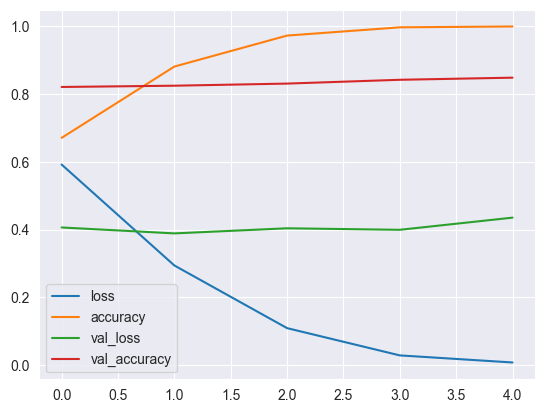

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(hist.history)
df.plot(legend=True, grid=True)
plt.show()

In [40]:
# https://www.tensorflow.org/guide/keras/save_and_serialize#to_json_and_tfkerasmodelsmodel_from_json
# Saving the architecture / configuration only, usually as a JSON file

model_dir = "models/model_chp07"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_structure = model.to_json()

with open(f"{model_dir}/cnn_model.json", "w") as json_file:
    json_file.write(model_structure)

model.save_weights(f"{model_dir}/cnn_weights.h5")
print('Model saved in json-format.')

HR()

model.save(
    f'{model_dir}/model_cnn', 
    overwrite=True,
    save_format='tf'
)
print('Model saved in tf-format.')

Model saved in json-format.
----------------------------------------


INFO:tensorflow:Assets written to: models/model_chp07/model_cnn/assets


INFO:tensorflow:Assets written to: models/model_chp07/model_cnn/assets


Model saved in tf-format.


<a name='7.4.7'></a><a id='7.4.7'></a>
## 7.4.7 Using the model in a pipeline
<a href="#top">[back to top]</a>

Problem: How to use a trained model?

Idea: Pass a new, unseen sample. We reinstatiate our model, if necessary.

In [41]:
from keras.models import model_from_json

print("Reinstatiating json-format model.")
# Load json-format model.
with open(f"{model_dir}/cnn_model.json", "r") as json_file:
    json_string = json_file.read()
model = model_from_json(json_string)

model.load_weights(f'{model_dir}/cnn_weights.h5')
print("Done")

Reinstatiating json-format model.
Done


In [42]:
# Load tf-format model.
print("Reinstatiating tf-format model.")
model2 = tf.keras.models.load_model(f'{model_dir}/model_cnn')
model2
print("Done")

Reinstatiating tf-format model.
Done


In [43]:
sample_1 = """I'm hate that the dismal weather that had me down for so long, 
when will it break! Ugh, when does happiness return?  
The sun is blinding and the puffy clouds are too thin.  
I can't wait for the weekend."""

In [44]:
# We pass a dummy value in the first element of the tuple just because our helper expects it from the way processed the initial data.  That value won't ever see the network, so it can be whatever.
vec_list = tokenize_and_vectorize([(1, sample_1)])
print(vec_list[0][0][:5])
HR()

# Tokenize returns a list of the data (length 1 here)
test_vec_list = pad_trunc(vec_list, maxlen)
test_vec = np.reshape(test_vec_list, (len(test_vec_list), maxlen, embedding_dims))
print(test_vec.shape)

[ 0.07910156 -0.0050354   0.11181641  0.21289062  0.13085938]
----------------------------------------
(1, 400, 300)


In [45]:
# 0 = negative review, 1 = positive review
sentiment_imdb = []
sentiment_imdb.append('Negative Sentiment')
sentiment_imdb.append('Positive Sentiment')

In [46]:
# Model 1, saved as json format
y_pred = model.predict(test_vec)
print(y_pred)
HR()

# If model is binary classification, eg sigmoid last-layer activation
res01 = (np.argmax(y_pred > 0.5))
print(res01)
sentiment_imdb[res01]

1/1 [==============================] - 0s 138ms/step
[[0.00088994]]
----------------------------------------
0


'Negative Sentiment'

In [47]:
# Model 2, saved in tf format
y_pred2 = model2.predict(test_vec)
print(y_pred)
HR()

res02 = (np.argmax(y_pred2 > 0.5))
print(res02)
sentiment_imdb[res02]

1/1 [==============================] - 0s 66ms/step
[[0.00088994]]
----------------------------------------
0


'Negative Sentiment'

<a name='7.4.8'></a><a id='7.4.8'></a>
## 7.4.8 Where do you go from here?
<a href="#top">[back to top]</a>

Problem: What is the potential of CNN for NLP classification tasks?

Idea: We may be able to create richer models by stacking convolutional layers and pssing the output of the earlier filters as the "image" sample into the next set, and so on. We can also run the model with multiple size filters and concatenate the output of each size filter into a longer thought vector, before passing it into the feedforward network at the end, to provide more accurate results. Also, in general CNNs can perform without relying on rich word embeddings. Lastly, CNNs are very efficient.